# Colorectal Cancer Clinical Trials
#### Analysis of completed colorectal cancer clinical trials using the ClinicalTrials.gov API

The purpose of this notebook is to download, filter and clean data retrieved from the ClinicalTrials.gov API and to do a simple analysis on some of the basic parameters related to clinical trials.

## 1. Imports & Data Retrieval

In [265]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
from matplotlib import font_manager
import seaborn as sns
from scipy.interpolate import interp1d
import scipy.stats as stats
import statsmodels.api as sm
from print_versions import print_versions

print_versions(globals())

pandas==2.2.2
requests==2.32.3
json==2.0.9
numpy==1.26.4
matplotlib==3.8.4
scipy==1.13.0
statsmodels.api==0.14.2
statsmodels==0.14.2
seaborn==0.13.2


In [266]:
# install custom fonts
font_files = font_manager.findSystemFonts(fontpaths="/Users/scc/miniconda3/envs/ml-base/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf")

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [267]:
# image parameters
%config InlineBackend.figure_format = 'svg'

mpl.rcParams['figure.figsize'] = (8, 5)
mpl.rcParams['font.family'] = 'Lato'  
mpl.rcParams['font.size'] = 14

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

mpl.rcParams['axes.linewidth']=0.7

In [268]:
# download data
SERVER = "https://clinicaltrials.gov/api/v2/studies"

parameters = {
    "query.cond": "colorectal cancer",
    "filter.overallStatus": "COMPLETED",
    "aggFilters": "results:with,status:com",
    "pageSize": "1000"
}

response = requests.get(url=SERVER, params=parameters)
response.raise_for_status
data = response.json()

In [269]:
# save locally as json file
with open('crc_trials.json', 'w') as f:
    json.dump(data, f)

In [270]:
# if working with a local file, it can be imported here.
with open('crc_trials.json') as f:
    data = json.load(f)

## 2. Data Preparation & Clean-up

Select the parameters of interest and add them to a dataframe. If a parameter can't be found, it gets added to the excluded list instead, which can be reviewed manually.

In [271]:
identifiers = []
start_dates = []
allocations = []
treatments = []
enrollments = []
phases = []
primary_outcomes = []
excluded = []
ages = []


for study in range(len(data["studies"])):
    try:
        # this needs to be worked out manually by looking at the structure of the api response
        identifier = data["studies"][study]["protocolSection"]["identificationModule"]["nctId"]
        start_date = data["studies"][study]["protocolSection"]["statusModule"]["startDateStruct"]["date"]
        allocation = data["studies"][study]["protocolSection"]["designModule"]["designInfo"]["allocation"]
        treatment = data["studies"][study]["protocolSection"]["designModule"]["designInfo"]["primaryPurpose"]
        enrollment = data["studies"][study]["protocolSection"]["designModule"]["enrollmentInfo"]["count"]
        phase = data["studies"][study]["protocolSection"]["designModule"]["phases"]
        primary_outcome = data["studies"][study]["resultsSection"]["outcomeMeasuresModule"]["outcomeMeasures"][0]["description"]
        # Extracting the mean age is a bit trickier, as it's not always in the same position. It also needs to be noted that it is always the mean age of the first category, which should be the control.
        if data["studies"][study]["resultsSection"]["baselineCharacteristicsModule"]["measures"][0]["title"] == "Age, Continuous":
            age = data["studies"][study]["resultsSection"]["baselineCharacteristicsModule"]["measures"][0]["classes"][0]["categories"][0]["measurements"][0]["value"]
            ages.append(age)
        elif data["studies"][study]["resultsSection"]["baselineCharacteristicsModule"]["measures"][1]["title"] == "Age, Continuous": 
            age = data["studies"][study]["resultsSection"]["baselineCharacteristicsModule"]["measures"][1]["classes"][0]["categories"][0]["measurements"][0]["value"]
            ages.append(age)
        else:
            ages.append("not known")

        start_dates.append(start_date)
        allocations.append(allocation)
        treatments.append(treatment)
        enrollments.append(enrollment)
        phases.append(phase)
        primary_outcomes.append(primary_outcome)
        identifiers.append(identifier)
    
    except:
        identifier = data["studies"][study]["protocolSection"]["identificationModule"]["nctId"]
        excluded.append(identifier)

In [272]:
print(f"{len(excluded)} studies were excluded from the dataframe due to missing parameters.")

69 studies were excluded from the dataframe due to missing parameters.


In [273]:
df = pd.DataFrame({
    'Identifier': identifiers,
    'Start Date': start_dates,
    'Allocation': allocations,
    'Treatment': treatments,
    'Enrollment': enrollments,
    'Phase': phases,
    'Primary Outcome': primary_outcomes,
    'Media/Mean Age of Ctrl Group': ages
})

In [274]:
df.head()

,Identifier,Start Date,Allocation,Treatment,Enrollment,Phase,Primary Outcome,Media/Mean Age of Ctrl Group
0,NCT04607291,2019-09-01,NA,HEALTH_SERVICES_RESEARCH,183,[PHASE1],"After CRC screening, satisfaction surveys will...",60.0
1,NCT02641691,2016-05-27,NA,TREATMENT,20,[PHASE2],* Criteria for complete clinical response:\n\n...,56.5
2,NCT00819780,2009-04-24,RANDOMIZED,TREATMENT,285,[PHASE2],PFS was defined as the time from the date of r...,61.6
3,NCT02000180,2013-06,RANDOMIZED,HEALTH_SERVICES_RESEARCH,37,[NA],The Joint Advisory Group (JAG) Direct Observat...,28.1
4,NCT01722162,2013-04,RANDOMIZED,TREATMENT,47,[PHASE2],* Time from start of treatment to the time of ...,62


In [275]:
print(f"The dataset has {df.shape[0]} entries with {df.shape[1]} parameters.")
if df.shape[0] > df.Identifier.nunique():
    print("There appear to be duplicates in the dataset. Please check.")

The dataset has 541 entries with 8 parameters.


## 3. Data Analysis

### Preliminary analysis of the data: how have clinical trials changed Over the Years in terms of total numbers and enrollments?

#### Number of Clinical Trials Over the Years

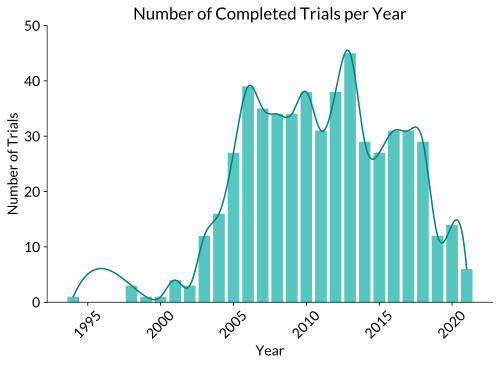

In [276]:
df['Start Date'] = pd.to_datetime(df['Start Date'], format='mixed')
df['Start Date'] = df['Start Date'].dt.to_period('M').dt.to_timestamp()
df['Year'] = df['Start Date'].dt.year

# Group by 'Year' and count trials
trials_per_year = df.groupby('Year').size()
x = trials_per_year.index
y = trials_per_year.values

# create interpolation for a smooth line
f = interp1d(x, y, kind='cubic')
x_new = np.linspace(x.min(), x.max(), 300)
y_smooth = f(x_new)


plt.plot(x_new, y_smooth, color="teal")
plt.bar(x, y, color="lightseagreen", alpha=0.75)

plt.title('Number of Completed Trials per Year')
plt.xlabel('Year')
plt.ylabel('Number of Trials')
plt.ylim(0, 50)
plt.xticks(rotation=45) 
plt.show()

ClinicalTrials.gov launched in 2000 as part of a law that required the NIH to create a database of trials. This explains the incline from 2000-2013, as more studies were added and more and more regulations resulted in more studies being required to use ClinicalTrials.gov. This dataset only contains trials with results, which could explain the decline from 2013 onwards, as many trials will not have been concluded.

#### Number of Enrollments per Trial

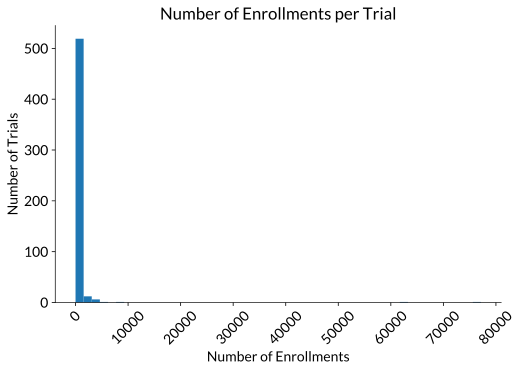

In [277]:
plt.hist(df['Enrollment'], bins=50)
plt.title('Number of Enrollments per Trial')
plt.xlabel('Number of Enrollments')
plt.ylabel('Number of Trials')
plt.xticks(rotation=45) 
plt.show()

When we plot the number of enrollments as a histogram, we see that most enrollments are < 5000, but that there are a few outliers with many participants, that we can't visualise like this. So instead, we're going to manually assign bins. This inherently introduces some bias and needs to be considered when interpreting the graph.

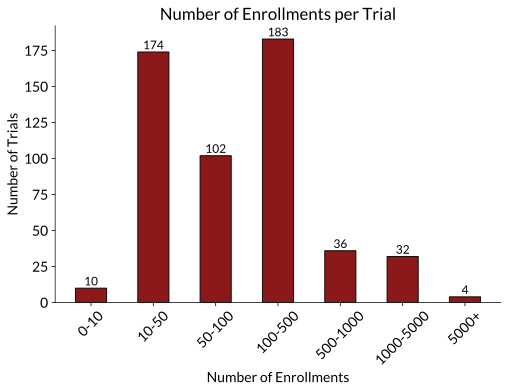

In [278]:
bins = [0, 10, 50, 100, 500, 1000, 5000, float('inf')] 
labels = ['0-10', '10-50', '50-100', '100-500', '500-1000', '1000-5000', '5000+'] 

df['Enrollment Category'] = pd.cut(df['Enrollment'], bins=bins, labels=labels, right=False)

enrollments_per_trial = df.groupby('Enrollment Category', observed=False).size()

bars = plt.bar(enrollments_per_trial.index, enrollments_per_trial.values, color="maroon", alpha=0.9, width=0.5, edgecolor='black')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom', fontsize=12)


plt.title('Number of Enrollments per Trial')
plt.xlabel('Number of Enrollments')
plt.ylabel('Number of Trials')
plt.xticks(rotation=45) 

plt.show()

#### Distribution of Median/Mean Age of Participants

In [279]:
# need to do a bit of clean-up because not all studies have an age
df_filtered = df[df['Media/Mean Age of Ctrl Group'] != "not known"]
df_filtered['Media/Mean Age of Ctrl Group'] = df_filtered['Media/Mean Age of Ctrl Group'].astype(float)

print(f"Mean of mean/median age across all studies: {df_filtered['Media/Mean Age of Ctrl Group'].mean()}")

Mean of mean/median age across all studies: 58.43536697247706


/var/folders/s7/cftykw3949l6pycny81h7_gr0000gn/T/ipykernel_14589/502743665.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Media/Mean Age of Ctrl Group'] = df_filtered['Media/Mean Age of Ctrl Group'].astype(float)


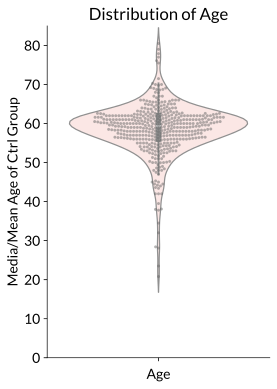

In [291]:
plt.figure(figsize=(4,6))
sns.violinplot(data=df_filtered['Media/Mean Age of Ctrl Group'], color="mistyrose")
sns.swarmplot(data=df_filtered['Media/Mean Age of Ctrl Group'], color="dimgray", size=3, alpha=0.5)
plt.title("Distribution of Age")
plt.xlabel("Age")
plt.ylim(0, 85)
plt.show()

/var/folders/s7/cftykw3949l6pycny81h7_gr0000gn/T/ipykernel_14589/2629819031.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x, fit_fn(x), 'r-', linewidth=2, color="crimson")


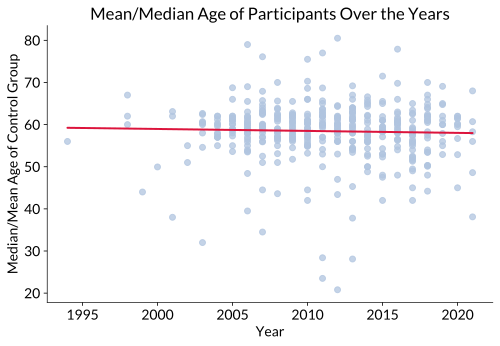

In [281]:
x = df_filtered['Year'] 
y = df_filtered['Media/Mean Age of Ctrl Group']

plt.scatter(x, y, color="lightsteelblue", alpha=0.75)

fit = np.polyfit(x, y, 1)  
fit_fn = np.poly1d(fit)

plt.plot(x, fit_fn(x), 'r-', linewidth=2, color="crimson") 

plt.title("Mean/Median Age of Participants Over the Years")
plt.xlabel("Year")
plt.ylabel("Median/Mean Age of Control Group")
plt.show()


#### Number of Enrollments Over the Years

/var/folders/s7/cftykw3949l6pycny81h7_gr0000gn/T/ipykernel_14589/2547062927.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x, fit_fn(x), 'r-', linewidth=2, color="crimson")


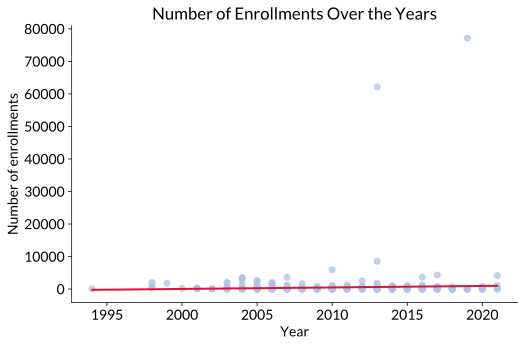

In [282]:
x = df['Year'].values
y = df['Enrollment'].values

plt.scatter(x, y, alpha=0.75, color="lightsteelblue")  

# Fit a linear model
fit = np.polyfit(x, y, 1)  
fit_fn = np.poly1d(fit)

# Plot the trend line
plt.plot(x, fit_fn(x), 'r-', linewidth=2, color="crimson") 

plt.title("Number of Enrollments Over the Years")
plt.xlabel("Year")
plt.ylabel("Number of enrollments")
plt.show()

This plot again shows that we have some outliers that make it difficult to interpret the data. So let's look at these outliers in a bit more detail. First, we fit a linear regression and calculate Cook's distance, which is used to estimate the influence of a data point.

In [283]:
# linear regression model
X = sm.add_constant(df['Year']) 
model = sm.OLS(df['Enrollment'], X).fit()

# Calculate Cook's distance
influence = model.get_influence()
cooks_distance = influence.cooks_distance[0]

# Identify outliers based on Cook's distance (outliers are defined as Cook's distance larger than 4/n)
outliers = cooks_distance > 4 / len(df)  

outliers_cooks_distance = cooks_distance[outliers]
print(outliers_cooks_distance)

outliers_enrollments = df['Enrollment'][outliers]
print(outliers_enrollments)

[0.21761426 1.05343524]
320    62155
336    77145
Name: Enrollment, dtype: int64


This data (together with the previous plot) shows that there are two trials with large numbers of enrollments. Before we proceed, we need to look at the data and decide whether they are realistic values.

In [284]:
df_sorted = df.sort_values(by='Enrollment', ascending=False)
df_sorted.head()

,Identifier,Start Date,Allocation,Treatment,Enrollment,Phase,Primary Outcome,Media/Mean Age of Ctrl Group,Year,Enrollment Category
336,NCT03843957,2019-10-01,RANDOMIZED,OTHER,77145,[NA],mPATH-CRC Implementation: Percent of all eligi...,55.0,2019,5000+
320,NCT01742065,2013-01-01,RANDOMIZED,SCREENING,62155,[NA],Binary indication of FIT completion within 12 ...,not known,2013,5000+
17,NCT01946282,2013-11-01,RANDOMIZED,HEALTH_SERVICES_RESEARCH,8565,[NA],Primary outcome was analyzed using an intent-t...,56,2013,5000+
462,NCT01191411,2010-10-01,RANDOMIZED,HEALTH_SERVICES_RESEARCH,5970,[NA],To compare participation rates for screening b...,59,2010,5000+
18,NCT02943265,2017-09-01,NA,HEALTH_SERVICES_RESEARCH,4322,[NA],Proportion of complex cancer survivors meeting...,57.5,2017,1000-5000


NCT03843957: study to learn how to best implement a new iPad program in clinical practice \
NCT01742065: screening study

Conclusion: the number of enrollments is most likely correct.

### Selection of studies that list "progression-free survival" (PFS) as their primary outcome

To draw conclusions on how number of participants has changed over the year, we need to refine our dataset. We are mostly interested in studies that measure progression-free survival as their primary outcome, so we select on that.

In [285]:
df_pfs = df[df['Primary Outcome'].str.contains("PFS|progression-free survival|progression free survival", case=False, na=False)]
print(f"{df_pfs.shape[0]} studies were selected that had a primary outcome of progression-free survival.")

62 studies were selected that had a primary outcome of progression-free survival.


/var/folders/s7/cftykw3949l6pycny81h7_gr0000gn/T/ipykernel_14589/3451721168.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x, fit_fn(x), 'r-', linewidth=2, color="crimson")


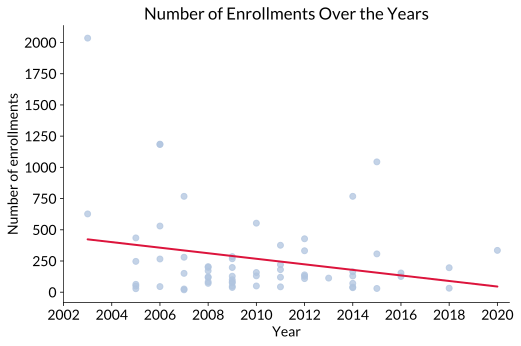

In [286]:
x = df_pfs['Year'].values
y = df_pfs['Enrollment'].values

plt.scatter(x, y, alpha=0.75, color="lightsteelblue")  

# Fit a linear model
fit = np.polyfit(x, y, 1)  
fit_fn = np.poly1d(fit)

# Plot the trend line
plt.plot(x, fit_fn(x), 'r-', linewidth=2, color="crimson") 

plt.title("Number of Enrollments Over the Years")
plt.xlabel("Year")
plt.ylabel("Number of enrollments")
plt.xlim(2002, 2020.5)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))


plt.show()

In [287]:
corr, p_value = stats.pearsonr(x, y)
alpha = 0.05

if p_value < alpha:
    print(f"The correlation between Year and Enrollments is significant (p-value: {p_value})")
else:
    print(f"The correlation between Year and Enrollments is not significant (p-value: {p_value})")

The correlation between Year and Enrollments is not significant (p-value: 0.058238358531272405)


#### Enrollment Categories of PFS Trials

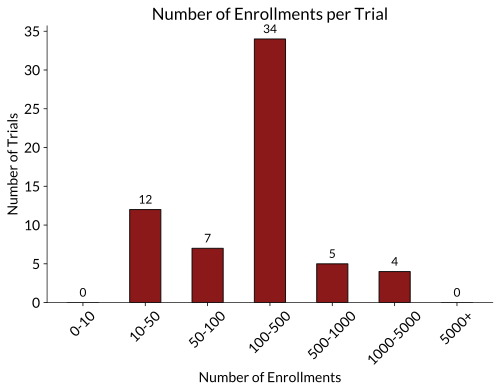

In [288]:
bins = [0, 10, 50, 100, 500, 1000, 5000, float('inf')] 
labels = ['0-10', '10-50', '50-100', '100-500', '500-1000', '1000-5000', '5000+'] 

enrollments_per_trial = df_pfs.groupby('Enrollment Category', observed=False).size()

bars = plt.bar(enrollments_per_trial.index, enrollments_per_trial.values, color="maroon", alpha=0.9, width=0.5, edgecolor='black')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom', fontsize=12)


plt.title('Number of Enrollments per Trial')
plt.xlabel('Number of Enrollments')
plt.ylabel('Number of Trials')
plt.xticks(rotation=45) 

plt.show()

Next, we're going to look at the distribution of phases. First, we need to restructure the dataframe so that it counts it as Phase 1 and Phase 2 when there are two phases.

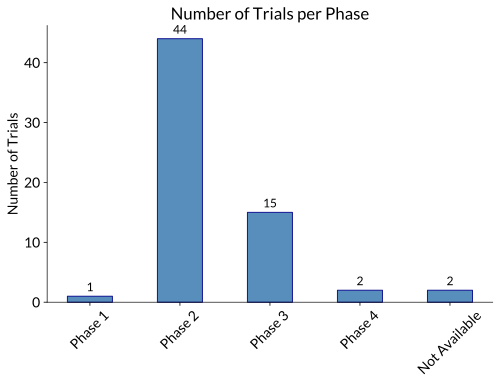

In [293]:
df_exploded = df_pfs.explode('Phase')
phase_counts = df_exploded['Phase'].value_counts()

order = ["PHASE1", "PHASE2", "PHASE3", "PHASE4", "NA"]
phase_counts = phase_counts.reindex(order)

bars = plt.bar(phase_counts.index, phase_counts.values, color="steelblue", alpha=0.9, width=0.5, edgecolor='darkblue')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom', fontsize=12)

plt.title("Number of Trials per Phase")
plt.xlabel("")
plt.ylabel("Number of Trials")
plt.xticks(range(len(phase_counts)), ['Phase 1', 'Phase 2', 'Phase 3', 'Phase 4', 'Not Available'], rotation=45) 
plt.show()

The majority of trials are phase 2. This makes sense as phase 2 tests efficacy.

## 4. Conclusions

The ClinicalTrials.gov API allows access to large datasets containing information about individual clinical trials. Accessing the specific data needed can be difficult as the data structure is not always the same.

There were no obvious trends in the number of enrollments or number of clinical trials over the years. The mean/median age and distribution of phases were as expected. 